In [29]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IDC Tutorial: Tissue classification in slide microscopy images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/cptac_use_case.ipynb)

This notebook demonstrates how to use the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non–small cell lung cancer histopathology images using deep learning" ([Coudray et al. 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into normal, adenocarcinoma (LUAD), and squamous cell carcinoma (LSCC) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be run in Google Colab. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. More complex use cases can be implemented using GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


## Customization

Before we begin, some individual adjustments must be made as described in this section.

This notebook is intended to be run using a **GPU**. In Google Colab, GPU usage can be enabled via `Edit > Notebooks Settings > Hardware accelerator`. Since Collab notebooks are assigned arbitrary GPUs (eg., NVIDIA K80, T4, P4 and P100), processing times can vary. The code below checks whether GPU usage has been enabled and which GPU type the Colab instance is equipped with.

In [59]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

True ['GPU 0: Tesla T4 (UUID: GPU-287a6fb7-9d59-2ccf-934f-b92961fa8d73)']


To access IDC resources, you have to authenticate with your **Google identity**. Follow the link generated by the code below and enter the displayed verification code to complete the Google authentication process.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Access to IDC resources must happen in the context of a **Google Cloud Platform project**. You can learn how to create your own project [here](https://www.youtube.com/watch?v=i08S0KJLnyw). Set `my_project_id` below to the ID of your GCP project.

In [60]:
my_project_id = 'idc-pathomics-000'

## Environment setup

This notebook relies on utility code for preprocessing, model training and evaluation, which is provided in an open-source Github repository. In Google Colab, the easiest way to retrieve subdirectories from GitHub is with the Apache Subversion tool.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y subversion 
!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/branches/development/idc_pathomics # use master instead of development branch later

Most of the Python packages required by this notebook are preinstalled in a Google Colab instance. In addition, we need to install the [OpenSlide](https://openslide.org/api/python/) library for accessing whole-slide images.

In [81]:
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install openslide-wrapper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libimagequant0 libopenslide0 libwebpdemux2 python3-pil
Suggested packages:
  python-pil-doc python3-pil-dbg
Recommended packages:
  python-openslide-examples python3-olefile
The following NEW packages will be installed:
  libimagequant0 libopenslide0 libwebpdemux2 python3-openslide python3-pil
0 upgraded, 5 newly installed, 0 to remove and 1 not upgraded.
Need to get 0 B/619 kB of archives.
After this operation, 1990 kB of additional disk space will be used.
Selecting previously unselected package libimagequant0:amd64.
(Reading database ... 115336 files and directories currently installed.)
Preparing to unpack .../libimagequant0_2.12.2-1.1_amd64.deb ...
Unpacking libimagequant0:amd64 (2.12.2-1.1) ...
Selecting previously unselected package libopenslide0.
Preparing to unpack .../libopenslide0_3.4.1+dfsg-4_amd64.deb ...
Unpacking libopensl

Import the required Python modules.

In [82]:
import os
import sys
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # Hide python warnings to improve readability.
    warnings.simplefilter('ignore')

Determine who and where we are.

In [122]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -rf sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Current directory : /home/jupyter/idc-pathomics-use-case-1
Hostname          : idc-patho-vm
Username          : jupyter


Create directories for input and output data.

In [123]:
#input_dir = os.path.join(curr_dir[-1], 'idc_input')
#output_dir = os.path.join(curr_dir[-1], 'idc_output')
# Use the following paths if using a Google Cloud VM instead of Google Colab
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'

if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they can be retrieved on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `idc-open` bucket.

Metadata for the DICOM files—including standard DICOM tags, but also non-DICOM metadata—are stored in the BigQuery table `dicom_all`. The IDC Documentation gives further information on [data organization](https://learn.canceridc.dev/data/organization-of-data) and [code examples](https://learn.canceridc.dev/cookbook/bigquery) on how to query the table. The easiest way to access BigQuery tables from a Jupyter notebook is to use [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) using the `%%bigquery` command. 

The following statement loads relevant metadata of all slide images from the CPTAC-LUAD and CPTAC-LSCC datasets into a pandas data frame called `slides_df`.

In [128]:
%%bigquery slides_df --project=$my_project_id 

SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS dataset,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    StudyInstanceUID AS idc_viewer_id,        
    gcs_url, -- URL of the Google Cloud storage bucket
    CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
          PixelMeasuresSequence[OFFSET(0)].
          PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    -- rename TransferSyntaxUIDs for readability
    CASE TransferSyntaxUID
        WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
        WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
        ELSE 'other'
    END AS compression
FROM idc-dev-etl.idc_v3.dicom_all
WHERE
  NOT (ContainerIdentifier IS NULL)
  AND (ClinicalTrialProtocolID = "CPTAC-LUAD" OR ClinicalTrialProtocolID = "CPTAC-LSCC")

Downloading: 100%|██████████| 11800/11800 [00:01<00:00, 9192.11rows/s]


We reduce the obtained data frame to the images we actually want to use for the analysis. Those are required to be digitized at 20x magnification (corresponding to a pixel spacing between 0.00025 and 0.00051 mm) and compressed in JPEG format (to be readable by the OpenSlide libray). Also, we consider only every 5th slide to make the dataset small enough to be manageable in Google Colab.

In [129]:
slides_df.query('pixel_spacing > 0.00025 & pixel_spacing < 0.00051 & compression=="jpeg"', inplace=True)
slides_df = slides_df.iloc[::40, :] # select every 5th row

The tissue type of the slides (tumor or normal) is not yet included in the `dicom_all` table. This information has to be supplemented from a separate CSV file provided by the TCIA. The cancer subtype (LSCC or LUAD) can in principle be inferred from the dataset name, but for clarity we also use the information in the CSV file.

In [130]:
type_df = pd.read_csv('idc_pathomics/tissue_type_data_TCIA.csv')[['Slide_ID', 'Specimen_Type', 'Tumor']]
# harmonize column names and labels
type_df.rename(columns={'Slide_ID': 'slide_id', 'Specimen_Type': 'tissue_type', 'Tumor': 'cancer_subtype'}, inplace=True)
type_df.replace({'tissue_type': {'normal_tissue': 'normal', 'tumor_tissue': 'tumor'}}, inplace=True)
type_df.replace({'cancer_subtype': {'LSCC': 'lscc', 'LUAD': 'luad'}}, inplace=True)
slides_df = pd.merge(slides_df, type_df, how='inner', on='slide_id', sort=True)

With standard [pandas](https://pandas.pydata.org/) functionality, we can easily validate and summarize the compiled metadata.

In [131]:
# Assert uniqueness of slide_id values
assert(slides_df.slide_id.is_unique)

# Assert validity of class labels
assert set(slides_df.tissue_type.unique()) == set(['normal', 'tumor'])
assert set(slides_df.cancer_subtype.unique()) == set(['luad', 'lscc'])

display(slides_df.head())
print('Total number of slides: ', len(slides_df))
nr_slides = slides_df.groupby('cancer_subtype').size()
nr_patients = slides_df.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression,tissue_type,cancer_subtype
0,C3L-00415-21,C3L-00415,CPTAC-LSCC,35855,25576,1.3.6.1.4.1.5962.99.1.2450214844.1765424608.16...,gs://idc_dev/c8a624f8-cbc4-4018-9729-3d10a671e...,0.000494,jpeg,tumor,lscc
1,C3L-00446-21,C3L-00446,CPTAC-LUAD,107567,35718,1.3.6.1.4.1.5962.99.1.2432787928.1914113533.16...,gs://idc_dev/ec97efb7-1a0c-438a-92f5-9b3882d66...,0.000494,jpeg,tumor,luad
2,C3L-00893-22,C3L-00893,CPTAC-LUAD,27887,22807,1.3.6.1.4.1.5962.99.1.2453873028.1674426507.16...,gs://idc_dev/2ff5ad06-874c-4050-83f2-ad7f8e943...,0.000494,jpeg,tumor,luad
3,C3L-01285-26,C3L-01285,CPTAC-LSCC,27887,26285,1.3.6.1.4.1.5962.99.1.2459218792.870550247.162...,gs://idc_dev/a6f0fcc4-5f08-4acf-a836-0cdebf47e...,0.000494,jpeg,normal,lscc
4,C3L-01862-23,C3L-01862,CPTAC-LUAD,19919,20126,1.3.6.1.4.1.5962.99.1.2460788490.1481744983.16...,gs://idc_dev/52c8f52d-7106-4722-9a0c-51e623c83...,0.000494,jpeg,tumor,luad


Total number of slides:  52
--> 28 slides from 27 LUAD patients
--> 24 slides from 23 LSCC patients


Using standard [matplotlib](https://matplotlib.org/) functionality, we can easily visualize some aspects of interest. The following code produces two histograms. The left graph shows the frequencies of numbers of slides per per patient, while the right graph shows the proportions of slides derived from healthy or tumor tissue.

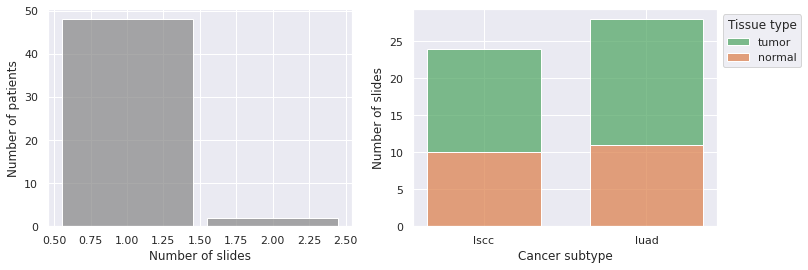

In [132]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# number of slides per patient 
slides_per_patient = slides_df.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})

# distribution of tissue types
plot2 = sns.histplot(data=slides_df, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C2', 'C1'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be easily viewed and explored in detail using the IDC viewer.

In [69]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[0]))
print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[100]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2461043434.326367772.1625958714090.3.0
https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2451408823.2122791306.1625949079479.3.0


Finally, we save the information as CSV file `slides_metadata.csv` to be used later for splitting into training, validation and test sets.

In [133]:
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_df.to_csv(slides_metadata_path, index=False)

## Pathomics experiment

The following pathomics experiment consists of three main steps:

1. **Preprocessing**:
    - Tiling of slides and filtering out of background tiles
    - Separation into training, validation and test dataset
2. **Training**: Per-tile training of the model
3. **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` given the respective gcs_url's. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. As this experiment is supposed to serve as a demo requiring a minimum amount of runtime, we further reduce the size of our dataset by generating only one in `twenty` tiles per slide. Still the tile generation will take roughly **xxx** time. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file (*patient_metadata.csv*) is created that reports the number of tiles available from each patient and is used to generate Figure 3 below. \
Additionally, we update *slides_metadata.csv* by adding the information whether a slide has been assigned to the training, validation or testset. 

In [134]:
from idc_pathomics.data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
if not os.path.exists(slides_dir):
    os.makedirs(slides_dir)

if not os.path.exists(tiles_dir):
    os.makedirs(tiles_dir)

generate_tiles(slides_dir, slides_metadata_path, tiles_dir, save_every_xth_tile=1, google_cloud_project_id=my_project_id)

1/52


Copying gs://idc_dev/c8a624f8-cbc4-4018-9729-3d10a671e8c3.dcm...


Processing slide C3L-00415-21 - 2021-09-23 13:15:50.302423


| [1 files][197.2 MiB/197.2 MiB]                                                
Operation completed over 1 objects/197.2 MiB.                                    


2/52


Copying gs://idc_dev/ec97efb7-1a0c-438a-92f5-9b3882d66d7b.dcm...


Processing slide C3L-00446-21 - 2021-09-23 13:16:56.864448


\ [1 files][  1.0 GiB/  1.0 GiB]   70.9 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


3/52


Copying gs://idc_dev/2ff5ad06-874c-4050-83f2-ad7f8e943102.dcm...


Processing slide C3L-00893-22 - 2021-09-23 13:20:30.546891


\ [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     


4/52


Copying gs://idc_dev/a6f0fcc4-5f08-4acf-a836-0cdebf47eea1.dcm...


Processing slide C3L-01285-26 - 2021-09-23 13:21:06.531056


| [1 files][140.2 MiB/140.2 MiB]                                                
Operation completed over 1 objects/140.2 MiB.                                    


5/52


Copying gs://idc_dev/52c8f52d-7106-4722-9a0c-51e623c8345d.dcm...


Processing slide C3L-01862-23 - 2021-09-23 13:21:47.268240


- [1 files][ 79.5 MiB/ 79.5 MiB]                                                
Operation completed over 1 objects/79.5 MiB.                                     


6/52


Copying gs://idc_dev/09a72195-dbe5-4b66-85af-c79310eededb.dcm...


Processing slide C3L-02127-26 - 2021-09-23 13:22:12.594815


/ [1 files][275.2 MiB/275.2 MiB]                                                
Operation completed over 1 objects/275.2 MiB.                                    


7/52


Copying gs://idc_dev/319392bd-ccd9-412a-8236-f18796b6feb6.dcm...


Processing slide C3L-02560-22 - 2021-09-23 13:23:58.053612


\ [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


8/52


Copying gs://idc_dev/ad6a0b1b-64fe-47b0-9b6e-41ded3cac2b4.dcm...


Processing slide C3L-02646-28 - 2021-09-23 13:24:23.870695


\ [1 files][130.1 MiB/130.1 MiB]                                                
Operation completed over 1 objects/130.1 MiB.                                    


9/52


Copying gs://idc_dev/73ddb9df-5faf-4f43-98e7-215317a13e3c.dcm...


Processing slide C3L-02648-21 - 2021-09-23 13:25:37.115550


- [1 files][413.0 MiB/413.0 MiB]                                                
Operation completed over 1 objects/413.0 MiB.                                    


10/52


Copying gs://idc_dev/681b277e-56e5-492a-9d18-150c226599f0.dcm...


Processing slide C3L-02650-30 - 2021-09-23 13:27:44.376918


- [1 files][ 33.8 MiB/ 33.8 MiB]                                                
Operation completed over 1 objects/33.8 MiB.                                     


11/52


Copying gs://idc_dev/2cbd617c-8b62-4c8a-b52f-5a33fcf6308c.dcm...


Processing slide C3L-02654-28 - 2021-09-23 13:27:59.663937


- [1 files][ 81.2 MiB/ 81.2 MiB]                                                
Operation completed over 1 objects/81.2 MiB.                                     


12/52


Copying gs://idc_dev/c8186fda-ccd9-4869-b5b8-106340b65c49.dcm...


Processing slide C3L-03268-22 - 2021-09-23 13:28:43.805787


\ [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    


13/52


Copying gs://idc_dev/e3f8744f-1032-49a2-b0d8-5bfe9697baca.dcm...


Processing slide C3L-03642-21 - 2021-09-23 13:29:15.584666


| [1 files][168.4 MiB/168.4 MiB]                                                
Operation completed over 1 objects/168.4 MiB.                                    


14/52


Copying gs://idc_dev/4c9f45fe-3abf-43ac-b677-be64903c42a3.dcm...


Processing slide C3L-03726-24 - 2021-09-23 13:29:43.315771


| [1 files][161.0 MiB/161.0 MiB]                                                
Operation completed over 1 objects/161.0 MiB.                                    


15/52


Copying gs://idc_dev/b61d62fc-2251-447f-815a-ffbd637efb34.dcm...


Processing slide C3L-03961-27 - 2021-09-23 13:30:45.405513


| [1 files][220.1 MiB/220.1 MiB]                                                
Operation completed over 1 objects/220.1 MiB.                                    


16/52


Copying gs://idc_dev/3188f7d0-b99d-474a-a908-9c8266292f1c.dcm...


Processing slide C3L-03963-23 - 2021-09-23 13:32:00.433690


- [1 files][349.1 MiB/349.1 MiB]                                                
Operation completed over 1 objects/349.1 MiB.                                    


17/52


Copying gs://idc_dev/8c23df50-9b5d-4d2d-8161-a3def4aa5707.dcm...


Processing slide C3L-03965-22 - 2021-09-23 13:33:36.103281


\ [1 files][393.7 MiB/393.7 MiB]                                                
Operation completed over 1 objects/393.7 MiB.                                    


18/52


Copying gs://idc_dev/524ca617-70a7-4c53-988c-5ed6839bee5e.dcm...


Processing slide C3L-03984-23 - 2021-09-23 13:35:13.430595


/ [1 files][270.7 MiB/270.7 MiB]                                                
Operation completed over 1 objects/270.7 MiB.                                    


19/52


Copying gs://idc_dev/7b2bafaf-92de-4fd0-ae02-c8d82ffad81a.dcm...


Processing slide C3L-04033-24 - 2021-09-23 13:36:43.558610


/ [1 files][261.9 MiB/261.9 MiB]                                                
Operation completed over 1 objects/261.9 MiB.                                    


20/52


Copying gs://idc_dev/dffc7a7d-c939-4e29-b0ac-0cae14e21a12.dcm...


Processing slide C3L-04040-28 - 2021-09-23 13:38:01.860791


- [1 files][ 91.7 MiB/ 91.7 MiB]                                                
Operation completed over 1 objects/91.7 MiB.                                     


21/52


Copying gs://idc_dev/ca78d731-e26c-4da6-9650-22a30304a925.dcm...


Processing slide C3L-04861-28 - 2021-09-23 13:38:57.432185


- [1 files][318.6 MiB/318.6 MiB]                                                
Operation completed over 1 objects/318.6 MiB.                                    


22/52


Copying gs://idc_dev/9a1a2e92-b517-43a7-b38a-9b909e2a292d.dcm...


Processing slide C3L-04874-21 - 2021-09-23 13:39:38.981312


| [1 files][172.2 MiB/172.2 MiB]                                                
Operation completed over 1 objects/172.2 MiB.                                    


23/52


Copying gs://idc_dev/472dcd51-e177-4c2b-9d19-bddd4c971a11.dcm...


Processing slide C3L-05020-24 - 2021-09-23 13:40:15.069500


- [1 files][ 77.5 MiB/ 77.5 MiB]                                                
Operation completed over 1 objects/77.5 MiB.                                     


24/52


Copying gs://idc_dev/1965aea9-9199-4425-aa9d-23b740c5aa78.dcm...


Processing slide C3L-05148-26 - 2021-09-23 13:40:43.115979


/ [1 files][401.8 MiB/401.8 MiB]                                                
Operation completed over 1 objects/401.8 MiB.                                    


25/52


Copying gs://idc_dev/b65af12e-0b63-452e-a367-e542e0ba4cf9.dcm...


Processing slide C3L-05172-25 - 2021-09-23 13:43:02.331241


/ [1 files][230.2 MiB/230.2 MiB]                                                
Operation completed over 1 objects/230.2 MiB.                                    


26/52


Copying gs://idc_dev/98b79477-8596-46fc-8269-2f10e20baa1b.dcm...


Processing slide C3L-05397-21 - 2021-09-23 13:43:51.430227


- [1 files][440.2 MiB/440.2 MiB]                                                
Operation completed over 1 objects/440.2 MiB.                                    


27/52


Copying gs://idc_dev/fe76d51f-5e50-419c-85f5-46fda2010de7.dcm...


Processing slide C3L-05397-22 - 2021-09-23 13:46:12.812626


- [1 files][441.4 MiB/441.4 MiB]                                                
Operation completed over 1 objects/441.4 MiB.                                    


28/52


Copying gs://idc_dev/2b47f96b-3c57-41fa-9f69-50c86d0722c8.dcm...


Processing slide C3L-05417-24 - 2021-09-23 13:48:16.211854


\ [1 files][390.6 MiB/390.6 MiB]                                                
Operation completed over 1 objects/390.6 MiB.                                    


29/52


Copying gs://idc_dev/6a3ca11b-e8b1-415c-aff8-1766b80b154b.dcm...


Processing slide C3N-00167-23 - 2021-09-23 13:50:58.580895


- [1 files][751.0 MiB/751.0 MiB]   74.4 MiB/s                                   
Operation completed over 1 objects/751.0 MiB.                                    


30/52


Copying gs://idc_dev/f4449e34-ff19-4fc1-856d-575f5c805fc3.dcm...


Processing slide C3N-00223-23 - 2021-09-23 13:53:18.992077


- [1 files][332.4 MiB/332.4 MiB]                                                
Operation completed over 1 objects/332.4 MiB.                                    


31/52


Copying gs://idc_dev/54144b98-03d5-4422-a687-91c7d8950f6d.dcm...


Processing slide C3N-00551-24 - 2021-09-23 13:55:09.138460


\ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


32/52


Copying gs://idc_dev/cee04577-3648-4f25-9cd4-57b1fb3562ec.dcm...


Processing slide C3N-00555-27 - 2021-09-23 13:56:47.254412


/ [1 files][271.5 MiB/271.5 MiB]                                                
Operation completed over 1 objects/271.5 MiB.                                    


33/52


Copying gs://idc_dev/f5e30a1a-cfec-4c1f-8533-fffca0aed7b6.dcm...


Processing slide C3N-00578-21 - 2021-09-23 13:58:17.298323


/ [1 files][441.0 MiB/441.0 MiB]                                                
Operation completed over 1 objects/441.0 MiB.                                    


34/52


Copying gs://idc_dev/755348c0-53ba-44b3-9f41-e7af83600925.dcm...


Processing slide C3N-00578-27 - 2021-09-23 14:00:03.900420


/ [1 files][275.9 MiB/275.9 MiB]                                                
Operation completed over 1 objects/275.9 MiB.                                    


35/52


Copying gs://idc_dev/1c0f96c8-265d-483e-9875-11ab665bcaec.dcm...


Processing slide C3N-00580-21 - 2021-09-23 14:01:27.048635


\ [1 files][373.4 MiB/373.4 MiB]                                                
Operation completed over 1 objects/373.4 MiB.                                    


36/52


Copying gs://idc_dev/2346a1a3-b4a3-4bb7-906d-b7ad4d56aba3.dcm...


Processing slide C3N-01016-26 - 2021-09-23 14:02:54.648402


\ [1 files][644.4 MiB/644.4 MiB]                                                
Operation completed over 1 objects/644.4 MiB.                                    


37/52


Copying gs://idc_dev/38eaeccf-67a1-4413-90d1-357793a01c45.dcm...


Processing slide C3N-01018-24 - 2021-09-23 14:05:32.125868


- [1 files][469.9 MiB/469.9 MiB]                                                
Operation completed over 1 objects/469.9 MiB.                                    


38/52


Copying gs://idc_dev/ee85c671-f396-4e8e-89fb-d2ef12b9d242.dcm...


Processing slide C3N-01023-26 - 2021-09-23 14:07:14.696005


/ [1 files][640.4 MiB/640.4 MiB]                                                
Operation completed over 1 objects/640.4 MiB.                                    


39/52


Copying gs://idc_dev/3bb8a839-282c-458b-8d2f-b138c556ac33.dcm...


Processing slide C3N-01410-27 - 2021-09-23 14:09:53.152624


/ [1 files][288.7 MiB/288.7 MiB]                                                
Operation completed over 1 objects/288.7 MiB.                                    


40/52


Copying gs://idc_dev/857f2ccb-a687-48c6-bf43-86c866589b5a.dcm...


Processing slide C3N-01413-24 - 2021-09-23 14:11:34.440654


- [1 files][377.0 MiB/377.0 MiB]                                                
Operation completed over 1 objects/377.0 MiB.                                    


41/52


Copying gs://idc_dev/c6034f87-7250-436b-8b87-baa76db68f49.dcm...


Processing slide C3N-01768-29 - 2021-09-23 14:13:05.576362


| [1 files][145.1 MiB/145.1 MiB]                                                
Operation completed over 1 objects/145.1 MiB.                                    


42/52


Copying gs://idc_dev/028dd613-2d93-442e-856b-00b7d6f3d775.dcm...


Processing slide C3N-02087-26 - 2021-09-23 14:14:09.206339


\ [1 files][393.5 MiB/393.5 MiB]                                                
Operation completed over 1 objects/393.5 MiB.                                    


43/52


Copying gs://idc_dev/548c6c42-69c5-4372-8bf1-90f750d0bae1.dcm...


Processing slide C3N-02149-26 - 2021-09-23 14:16:15.064243


\ [1 files][517.4 MiB/517.4 MiB]                                                
Operation completed over 1 objects/517.4 MiB.                                    


44/52


Copying gs://idc_dev/db4dc118-ed67-48a1-a13d-41266af2bbd5.dcm...


Processing slide C3N-02718-23 - 2021-09-23 14:18:41.629150


- [1 files][316.1 MiB/316.1 MiB]                                                
Operation completed over 1 objects/316.1 MiB.                                    


45/52


Copying gs://idc_dev/6942819a-fb70-44f4-839e-996164b26eba.dcm...


Processing slide C3N-02721-26 - 2021-09-23 14:20:48.316916


| [1 files][627.5 MiB/627.5 MiB]                                                
Operation completed over 1 objects/627.5 MiB.                                    


46/52


Copying gs://idc_dev/e08b9910-bdb8-4829-8048-e04e295c4780.dcm...


Processing slide C3N-03063-22 - 2021-09-23 14:23:26.556824


\ [1 files][117.4 MiB/117.4 MiB]                                                
Operation completed over 1 objects/117.4 MiB.                                    


47/52


Copying gs://idc_dev/482ac079-d6e8-44ab-9104-5e381116fcbd.dcm...


Processing slide C3N-03424-23 - 2021-09-23 14:23:59.218880


| [1 files][167.4 MiB/167.4 MiB]                                                
Operation completed over 1 objects/167.4 MiB.                                    


48/52


Copying gs://idc_dev/0aa0f2d3-cae2-4a8f-a8bb-5884c87cb411.dcm...


Processing slide C3N-03877-23 - 2021-09-23 14:25:13.915657


- [1 files][ 94.4 MiB/ 94.4 MiB]                                                
Operation completed over 1 objects/94.4 MiB.                                     


49/52


Copying gs://idc_dev/757c5506-958b-451b-869f-f9ae44ed72af.dcm...


Processing slide C3N-03890-23 - 2021-09-23 14:26:02.342886


- [1 files][475.0 MiB/475.0 MiB]                                                
Operation completed over 1 objects/475.0 MiB.                                    


50/52


Copying gs://idc_dev/bf9c7927-685d-4677-a9d4-16eafe93dad7.dcm...


Processing slide C3N-04127-22 - 2021-09-23 14:27:55.692782


- [1 files][ 56.0 MiB/ 56.0 MiB]                                                
Operation completed over 1 objects/56.0 MiB.                                     


51/52


Copying gs://idc_dev/cf3e55f7-968e-4235-8cbc-609876d57e02.dcm...


Processing slide C3N-04162-23 - 2021-09-23 14:28:20.366013


/ [1 files][576.2 MiB/576.2 MiB]                                                
Operation completed over 1 objects/576.2 MiB.                                    


52/52


Copying gs://idc_dev/a7a9a3d5-76f1-41bd-983a-c6f332595aac.dcm...


Processing slide C3N-04168-26 - 2021-09-23 14:31:09.911034


\ [1 files][506.3 MiB/506.3 MiB]                                                
Operation completed over 1 objects/506.3 MiB.                                    


In [135]:
from idc_pathomics.data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata

We visualize some (random) tiles from the training dataset:

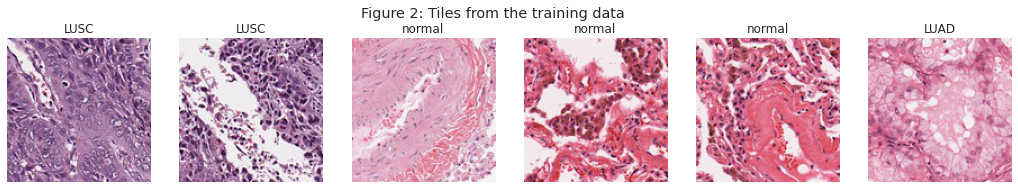

In [137]:
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'} # internal representation of classes is numeric
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Figure 2: Tiles from the training data')
for i, idx in enumerate([2000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

Further, we inspect visually how many tiles there are per patient (due to different sizes of slides and amount of slides per patient): 

Total number of tiles: 79,958


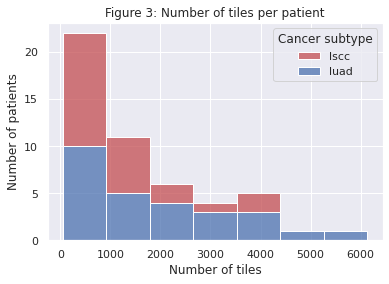

In [138]:
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Figure 3: Number of tiles per patient')
fig3.update({'xlabel': 'Number of tiles', 'ylabel': 'Number of patients'})
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

### Training

**Network training**: Following Coudray *et al.*, we use the InceptionV3 network architecture as implemented by Keras and depicted in the image below. The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves. 

![inceptionV3.png](idc-pathomics/inceptionV3.png)

In [ ]:
from idc_pathomics.data.data_set import Dataset
from idc_pathomics.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=30, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

Epoch 1/30
101/101 [==============================] - 123s 1s/step - loss: 0.8717 - auc_13: 0.8737 - val_loss: 5294.6870 - val_auc_13: 0.4280
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210923_143444/checkpoint_001/assets
Epoch 2/30
101/101 [==============================] - 118s 1s/step - loss: 0.5462 - auc_13: 0.9475 - val_loss: 2.8018 - val_auc_13: 0.4725
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210923_143444/checkpoint_002/assets
Epoch 3/30
101/101 [==============================] - 118s 1s/step - loss: 0.3576 - auc_13: 0.9703 - val_loss: 2.4402 - val_auc_13: 0.5299
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210923_143444/checkpoint_003/assets
Epoch 4/30
101/101 [==============================] - 118s 1s/step - loss: 0.3300 - auc_13: 0.9734 - val_loss: 12.8856 - val_auc_13: 0.7459
Epoch 5/30
101/101 [==============================] - 117s 1s/step - loss: 0.2649 - auc_13: 0.9807 - val_loss: 1.6653 - val_auc_13: 0.7492
INFO:te

### Evaluation

The final model is selected as the one with the best (minimal) loss on the validation dataset. The performance of this model is evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. First, the model makes predictions for the entire test set and stores them in the experiment's output directory to make subsequent evaluation easily repeatable. 

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide are aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized in Figure 4. In addition to the ROC curves for each class, a micro-average ROC is computed and visualized. 

**Heatmaps** for visually inspecting the network's predictions for some of the slides. The color of each tile corresponds to the class assigned by our model, with the hue indicating how confident the network is in this classification. Hereby a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. The generation of a thumbnail image takes ~1min, thus we limit ourselves to showing heatmaps for only 4 random slides from the testset. 

In [113]:
# Load the best model 
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
best_model = InceptionModel.load(best_model_dir)

In [120]:
from idc_pathomics.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc.csv'), num_classes=3)
#test_dataset = Dataset('/home/jupyter/idc_input_10slide_20tile/test_norm_luad_lscc.csv', num_classes=3)

predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_testset.json'))

In [121]:
from idc_pathomics.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.803               0.975               0.963
LUAD            0.719               0.655               0.630
LUSC            0.770               0.850               0.860
Micro           0.714               0.749               0.746

In [43]:
%%capture --no-display
from idc_pathomics.data.utils import get_random_testset_slide_ids, get_thumbnail, get_slide_tissue_type
from idc_pathomics.evaluation.heatmap import get_heatmap, plot_colormap_legend
from idc_pathomics.evaluation.predictions import Predictions

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
get_thumbnail(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id) # NOTE: lasts ~1min per slide

# Generate figure 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Figure 5: Heatmap visualization')
for i in range(4):
    slide_id = heatmap_slide_ids[i]#'C3L-00913-22'#
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    axes[i,0].imshow(get_heatmap(predictions, slide_id))
    axes[i,1].imshow(slide1)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')

ValueError: a must be greater than 0 unless no samples are taken